# MyND Offline Processing: Data Analysis
Author: Geeling Chau<br> 
Description: Process xdf files recorded from experimental sessions to determine file eligibility and data feature extraction.<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp


## TODO
- [X] standard error bars
- [x] reaction time analysis
- [ ] word length analysis
- [X] Psychopy adjust difficulty 
- [X] flash memes

## Imports

In [318]:
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import *

import warnings
warnings.filterwarnings('ignore')

In [319]:
import scipy as sp

In [320]:
from neurodsp.timefrequency import amp_by_time

## Constants

In [321]:
alpha = (8, 12)
theta = (4, 7)

In [322]:
start_marker_string = getLabelMarkerString("newWord")
end_marker_string = getLabelMarkerString("endWord")
target_word_string = getSingleLabelMarkerString("targetWord")
space_pressed_string = getSingleLabelMarkerString("spacePressed")
response_start_string = getSectionMarkerString("response")[0] # Get the 0th element to get the start string
space_pressed_string = getLabelMarkerString("spacePressed")
letters_shown_string = getLabelMarkerString("lettersShown")
meme_shown_string = getLabelMarkerString("memeShown")


In [323]:
meme_shown_string

'--MemeShown'

## Helper Functions

In [324]:
def getAmpByTimeLeftRight(data_frame, eeg_fs, band, cutoff_timepoints) :
    amp_rights = list()
    amp_lefts = list() 

    for i, row in data_frame.iterrows(): 
        sig_right = row["data"][StreamType.EEG.value][StreamType.DATA.value][:, channels["right_eeg"]][:cutoff_timepoints]
        amp_right = amp_by_time(sig_right, eeg_fs, band)
        amp_rights.append(amp_right[~np.isnan(amp_right)])

        sig_left = row["data"][StreamType.EEG.value][StreamType.DATA.value][:, channels["left_eeg"]][:cutoff_timepoints]
        amp_left = amp_by_time(sig_left, eeg_fs, band)
        amp_lefts.append(amp_left[~np.isnan(amp_left)])
        
    return amp_lefts, amp_rights

In [325]:
def getTrials(data):
    data_list, a, t_data = getLabelBoundSingleLabelData("newWord", "endWord", data, go_backward=False)
    return data_list

In [326]:
def getReactionTime(data) :
    markers = data[StreamType.MARKER.value][StreamType.DATA.value]
    times = data[StreamType.MARKER.value][StreamType.TIME.value]
    if (PSYCHO_PY_MARKERS["spacePressed"] in markers) and (PSYCHO_PY_MARKERS["spacePressed"] in markers): 
        
        index_space = np.where(data[StreamType.MARKER.value][StreamType.DATA.value] == PSYCHO_PY_MARKERS["spacePressed"])[0]
        index_start = np.where(data[StreamType.MARKER.value][StreamType.DATA.value] == PSYCHO_PY_MARKERS["newWord"])[0]
        
        return (times[index_space] - times[index_start])[0]
    else:
        return 0

In [327]:
def getReactionTimes(data_list) :

    reaction_times = list()
    for data in data_list: 
        reaction_times.append(getReactionTime(data))
    
    return reaction_times

In [328]:
def compareDFs(dfs, names, band=alpha, eeg_fs=250, cutoff_timepoints=250):
    counter=0
    for df in dfs:  
        print(names[counter]+" len:" ,  len(df))
        counter+=1
    
    amp_lefts=list()
    amp_rights=list()
    amp_avg=list()
    amp_diff=list()
    sem_avgs = list()
    sem_diffs = list()
    
    for df in dfs: 
        amp_lefts1, amp_rights1 = getAmpByTimeLeftRight(df, eeg_fs=eeg_fs, band=band, cutoff_timepoints=cutoff_timepoints)
        amp_lefts.append(amp_lefts1)
        amp_rights.append(amp_rights1)
        
        avg_list_sub = list()
        diff_list_sub = list()
        for i in range(len(amp_lefts1)) :
            avg_list_sub.append(np.mean([amp_lefts1[i], amp_rights1[i]], axis=0))
            diff_list_sub.append(amp_lefts1[i] - amp_rights1[i])
        amp_avg.append(avg_list_sub)
        amp_diff.append(diff_list_sub)
        
        sem_avgs.append(sp.stats.sem(avg_list_sub,axis=0))
        sem_diffs.append(sp.stats.sem(diff_list_sub,axis=0))
        
    
    # Average amp by time Alpha
    for i in range(len(amp_avg)) : 
        av = np.nanmean(amp_avg[i], axis=0)
        plt.plot(av, label=names[i])
        plt.fill_between(list(range(len(av))), av-sem_avgs[i], av+sem_avgs[i], alpha = 0.2)

    plt.title("Average amp by time")
    plt.ylabel("power of band")
    plt.xlabel("timepoints from start of word")
    plt.legend()
    plt.show()
    
#     # Diff amp by time Alpha
#     for i in range(len(amp_lefts)) : 
#         dif = np.nanmean(amp_diff[i], axis=0)
#         plt.plot(dif, label=names[i])
#         plt.fill_between(list(range(len(dif))), dif-sem_diffs[i], dif+sem_diffs[i], alpha = 0.2)
        
#     plt.title("Diff amp by time")
#     plt.ylabel("power of band")
#     plt.xlabel("timepoints from start of word")
#     plt.legend()
#     plt.show()
    
    

In [329]:
def getSmoothedPerformance(original_performance, num_ahead=1, num_behind=1): 
    # num_ahead: the number of elements to check ahead of this element
    # num_behind: the number of elements to check behind this element
    to_return = list()
    for i in range(len(original_performance)):
        value = False
        for j in range(1, num_ahead+1):
            if i >= j: 
                if original_performance[i-j]: 
                    value = True
                    break
        for j in range(1, num_behind+1):
            if i < len(original_performance) - j:
                if original_performance[i+j]: 
                    value = True
                    break
        if original_performance[i]:
            to_return.append(True)
        else : 
            to_return.append(value)
    return to_return

## Main

### Get Data

In [330]:
'''
Files that work with this notebook: 
participant_P004_exp001_block_full_start.xdf # full start
participant_P004_exp002_block_full_start.xdf # This should work: after restarting computer
participant_P004_exp003_block_full_start.xdf # This should work too
participant_P004_exp001_block_full_short.xdf # Works
participant_P004_exp001_block_full_long.xdf # Works

participant_P001_exp001_block_full_long.xdf # Me, very sleepy. 

P001/participant_P001_exp001_block_long.xdf 
P001/participant_P001_exp001_block_short.xdf # Meme shown markers are wonky 
P001/participant_P001_exp001_block_start.xdf # before changing the point system on the "m" press

participant_P001_exp001_block_test_markers.xdf # Meme shown markers should be fixed

P005/participant_P005_exp001_block_start.xdf # 
P005/participant_P005_exp001_block_short.xdf # 
P005/participant_P005_exp001_block_long.xdf # Full set with new markers and point system


'''

XDF_Data = loadxdf("../data/P001/participant_P001_exp001_block_long.xdf")
if StreamType.EEG.value in XDF_Data :
    eeg_fs = getEEGfs(XDF_Data)
    print("eeg_fs = ", eeg_fs)
if StreamType.EYE.value in XDF_Data : 
    eye_fs = getEYEfs(XDF_Data) 
    print("eye_fs = ", eye_fs)
# Trim the data to only include the time PsychoPy was running
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

marker_indexes = getMarkerIndexes(XDF_Data)

# Recording data checks (whether all markers are there etc)
markersFound = True
for marker_key in PSYCHO_PY_MARKERS : 
    if PSYCHO_PY_MARKERS[marker_key] not in marker_indexes.keys(): 
        markersFound = False 
        print("Missing Marker:", PSYCHO_PY_MARKERS[marker_key])
print("All Markers Found?", markersFound)
    
print("\n\ncheck calibration markers:\n\n",XDF_Data[StreamType.MARKER.value][StreamType.DATA.value][:20])


eeg_fs =  250
eye_fs =  33
Missing Marker: --InstructionStart
Missing Marker: --InstructionStop
Missing Marker: --MemeHidden
All Markers Found? False


check calibration markers:

 [['--PsychopyStart']
 ['(0, 0)']
 ['Calibration stage \n\nFollow the instructions that pop up, while keeping head as still as possible.']
 ['--SpacePressed']
 ['--CalibrationStart']
 ['(0, 0)']
 ['Blink twice\n\nthen Press Space']
 ['--SpacePressed']
 ['(0, 0)']
 ['Try not to blink, look at the center of your screen, and count to 5\n\nthen Press Space']
 ['--SpacePressed']
 ['(0, 0)']
 ['Close your eyes and count to 5\n\nthen Press Space']
 ['--SpacePressed']
 ['(0, 0)']
 ['Relax for at least 5 seconds\n\nthen Press Space']
 ['--SpacePressed']
 ['(0, 0)']
 ['Enjoy These Memes (press space to advance through each)']
 ['--SpacePressed']]


## Filtering

### Filter 1-50 Hz

In [331]:
filtered_data = filterStreamStructEEG(XDF_Data)

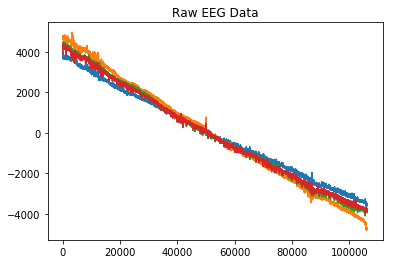

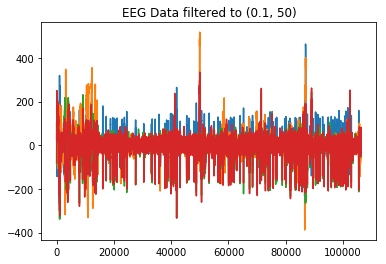

In [332]:
# Check filtering
for channel in channels: 
    eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("Raw EEG Data")
plt.show()

for channel in channels: 
    eeg_data = filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("EEG Data filtered to " + str(f_range))
margin =  800 #len(freq) // 2 means all. 600 to see 60Hz
plt.show()

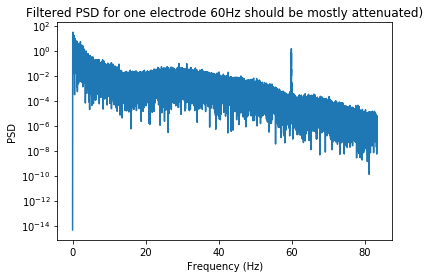

In [333]:
freq, psd = signal.periodogram(filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels["right_eeg"]], fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD') # not sure what the unit is...
plt.title('Filtered PSD for one electrode 60Hz should be mostly attenuated)')
plt.semilogy(freq[: int(len(freq) / 1.5)], psd[: int(len(freq) / 1.5)])
plt.show()


## Clean artifacts from VEOG

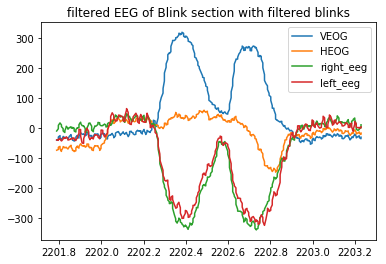

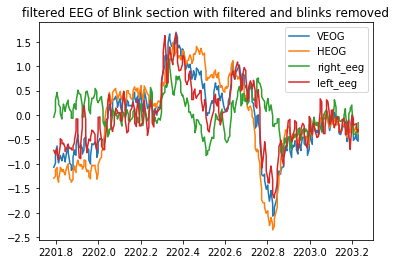

In [334]:
#Filter the entire EEG data

# Show original blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

line_objects = plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()

#Filter the entire EEG data
filtered_cleaned_data  = getCleanedSignal(filtered_data, verbose=False)


# Show the cleaned data at the blink section
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_cleaned_data)
blink_data = new_data[0]

line_objects = plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered and blinks removed")
plt.show()


## Get points for each section

In [335]:
# Get sections
numSections = getNumSections(filtered_cleaned_data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, filtered_cleaned_data))


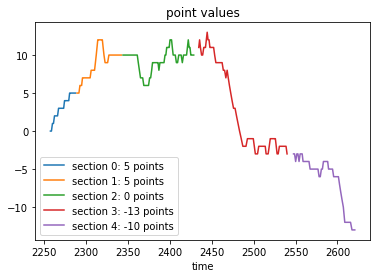

In [336]:
for i, article_section in enumerate(article_sections):
    data, time = getPointsAfterEachWord(article_section)
    num_delta_points = getTotalPoints(article_section)
    plt.plot(time[:], data[:], label="section " + str(i) + ": " + str(num_delta_points) + " points")
plt.title("point values")
plt.xlabel("time")
plt.legend()
plt.show()

## Get meme show and hide times

In [337]:
meme_is_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
if len(meme_is_shown_data) == 0: 
    articles_with_memes = list()
    articles_without_memes = list() 
    for section in article_sections:
        if meme_shown_string in section[StreamType.MARKER.value][StreamType.DATA.value] :
            articles_with_memes.append(section)
        else : 
            articles_without_memes.append(section)
    meme_is_shown_data = articles_with_memes

In [338]:
# Determine the time frames in which the memes are shown
# meme_is_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
meme_shown_times = list() 
for data in meme_is_shown_data:
    start_time = data[StreamType.MARKER.value][StreamType.TIME.value][0]
    end_time = data[StreamType.MARKER.value][StreamType.TIME.value][-1]
    meme_shown_times.append((start_time, end_time))


## Finer Epoching
Target vs Nontarget <br> 
SpacePressed vs NoSpacePressed <br> 
Meme vs No Meme

In [339]:
# Construct data frame 

# This version doesn't work because we need to know when the neew article starts. 
# new_word_data, a, t_data = getLabelBoundSingleLabelData("newWord", "endWord", filtered_cleaned_data, go_backward=False)
# points = [getTotalPoints(data) for data in new_word_data] 


new_word_data, a, t_data = getTimeBoundSingleLabelData("newWord", filtered_cleaned_data, time_before=0.5, time_after=1.5)
points = [getTotalPoints(data) for data in new_word_data] 

data_info = dict() 
data_info["data_index"] = list() 
data_info["data"] = list() 
data_info["is_target"] = list() 
data_info["is_pressed"] = list()
data_info["has_letters_shown"] = list() 
data_info["has_meme"] = list() 
data_info["time"] = list() 
data_info["points"] = list() 
data_info["reaction_time"] = list() 
data_info["section_number"] = list()


section_number = 0

end_times = list()
for i, point in enumerate(points):
    if(response_start_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value]) : 
        section_number += 1
    
    # Find this word's start and end indexes 
    marker_indexes = getMarkerIndexes(new_word_data[i])
    start_word_index = marker_indexes[start_marker_string][0]
    end_word_index = marker_indexes[end_marker_string][-1]
    end_time = float(new_word_data[i][StreamType.MARKER.value][StreamType.TIME.value][end_word_index])
    end_times.append(end_time)
    # Determine if meme was shown
    has_meme = False
    for meme_shown_interval in meme_shown_times: 
        if (end_time > meme_shown_interval[0] and end_time < meme_shown_interval[1]) :
            has_meme = True
            break

    # Determine if word is a target word
    is_target = False
    if target_word_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_target = True
    
    # Determine if word was pressed on 
    is_pressed = False
    if space_pressed_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_pressed = True
        
    # Determine if word had letters shown
    has_letters_shown = False
    if letters_shown_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        has_letters_shown = True
    
    # Get reaction time
    data_list = getTrials(new_word_data[i])
    this_data = data_list[0]
    reaction_time = getReactionTime(this_data)
    
    
    data_info["data_index"].append(i)
    data_info["data"].append(new_word_data[i])
    data_info["is_target"].append(is_target)
    data_info["is_pressed"].append(is_pressed)
    data_info["has_letters_shown"].append(has_letters_shown)
    data_info["has_meme"].append(has_meme)
    data_info["time"].append(t_data[i])
    data_info["points"].append(point)
    data_info["section_number"].append(section_number)
    data_info["reaction_time"].append(reaction_time)

df = pd.DataFrame.from_dict(data_info)

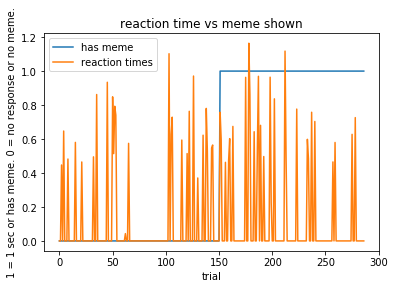

This shows if there's any correlation between showing the memes and a elongation of reaction time


In [340]:
plt.plot(df["has_meme"], label="has meme")
plt.plot(df["reaction_time"], label="reaction times")
plt.xlabel("trial")
plt.ylabel("1 = 1 sec or has meme. 0 = no response or no meme.")
plt.title("reaction time vs meme shown")
plt.legend()
plt.show()

print("This shows if there's any correlation between showing the memes and a elongation of reaction time")

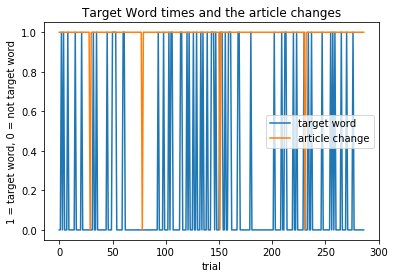

This shows the distribution of target words shown


In [341]:
plt.plot(df["is_target"], label="target word")
plt.plot([ 0 if (i > 0) and (df["section_number"][i-1] != df["section_number"][i]) else 1 for i, row in df.iterrows()], label="article change")
plt.title("Target Word times and the article changes")
plt.xlabel("trial")
plt.ylabel("1 = target word, 0 = not target word")
plt.legend()
plt.show()

print("This shows the distribution of target words shown")

alpha
unfocused len: 191
focused len: 96


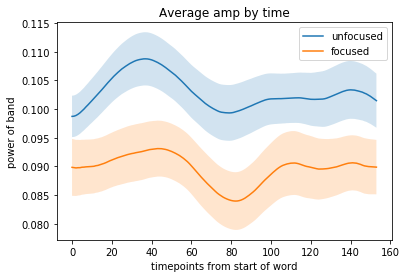

theta
unfocused len: 191
focused len: 96


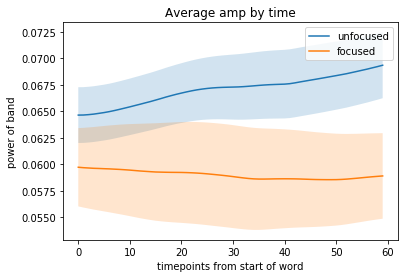

In [342]:
unfocused_state = getSmoothedPerformance((df["is_pressed"] == False) & (df["is_target"] == True), 10, 3)
unfocused_df = df[unfocused_state]
focused_df = df[np.logical_not(unfocused_state)]
print("alpha")
compareDFs([ unfocused_df, focused_df],[ "unfocused", "focused"], band=alpha )
print("theta")
compareDFs([ unfocused_df, focused_df],[ "unfocused", "focused"], band=theta )


alpha
all len: 287
correct len: 36
missed len: 22


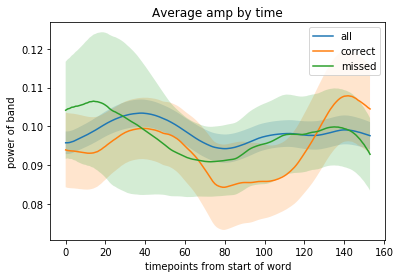

theta
all len: 287
correct len: 36
missed len: 22


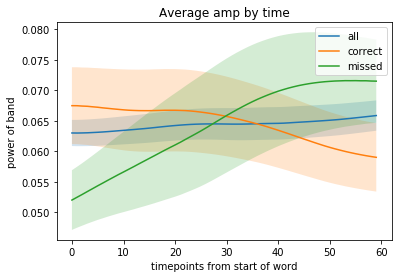

In [343]:
correct_df = df[(df["is_pressed"] == True) & (df["is_target"] == True)] 
missed_df = df[(df["is_pressed"] == False) & (df["is_target"] == True)] 
print("alpha")
compareDFs([df, correct_df, missed_df],["all", "correct", "missed"], band=alpha )
print("theta")
compareDFs([df, correct_df, missed_df],["all", "correct", "missed"], band=theta )


In [ ]:
slow_react_df = df[(df["is_pressed"] == True) & (df["is_target"] == True) & (df["reaction_time"] > 0.6)] 
fast_react_df = df[(df["is_pressed"] == True) & (df["is_target"] == True) & (df["reaction_time"] < 0.6)] 
print("alpha")
compareDFs([df, slow_react_df, fast_react_df],["all", "slow", "fast"], band=alpha )
print("theta")
compareDFs([df, slow_react_df, fast_react_df],["all", "slow", "fast"], band=theta )


In [ ]:
meme_df = df[(df["has_meme"] == True)]
nomeme_df = df[(df["has_meme"] == False)]
print("alpha")
compareDFs([df, meme_df, nomeme_df],["all", "meme", "nomeme"], band=alpha )
print("theta")
compareDFs([df, meme_df, nomeme_df],["all", "meme", "nomeme"], band=theta )


In [ ]:
error_df = df[(df["points"] < 0)]
good_df = df[(df["points"] > 0)]
print("alpha")
compareDFs([df, error_df, good_df],["all", "error", "good"], band=alpha )
print("theta")
compareDFs([df, error_df, good_df],["all", "error", "good"], band=theta )



In [ ]:
from fooof import FOOOF, FOOOFGroup

In [ ]:
def getEEGFromDataFrame_AvgLeftRight(df):
    eeg_list = list()
    for i, row in df.iterrows():
        data = row["data"]
        left_eeg = data[StreamType.EEG.value][StreamType.DATA.value][:,channels['left_eeg']]
        right_eeg = data[StreamType.EEG.value][StreamType.DATA.value][:,channels['right_eeg']]
        avg_eeg = np.mean([left_eeg, right_eeg], axis=0)
        eeg_list.append(avg_eeg)
    return eeg_list

In [ ]:
def getEEGFromDataList_AvgLeftRight(data_list):
    eeg_list = list() 
    for data in data_list: 
        left_eeg = data[StreamType.EEG.value][StreamType.DATA.value][:,channels['left_eeg']]
        right_eeg = data[StreamType.EEG.value][StreamType.DATA.value][:,channels['right_eeg']]
        avg_eeg = np.mean([left_eeg, right_eeg], axis=0)
        eeg_list.append(avg_eeg)
    return eeg_list

In [ ]:
# Data from calibration phase
# May need to change this depending on the dataset and the available markers. 
# Older datasets may not have the start and end markers that are helpful for directly getting the section data. 
# Older datasets may also have different identifying text. 
data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Try not to blink, look at the center of your screen, and count to 5\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)
data_relax, index, index_sub = getMarkerBoundSingleMarkerData('Relax for at least 5 seconds\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)
data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes and count to 5\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)

data_list = [data_open_eyes[0], data_relax[0], data_close_eyes[0]]


In [ ]:
eeg_list = getEEGFromDataList_AvgLeftRight(data_list)
fits = getFOOOFFits(eeg_list, (1,40))
fits[1].plot()

In [ ]:
fits[2].plot()

In [ ]:
all_left = filtered_cleaned_data[StreamType.EEG.value][StreamType.DATA.value][:,channels['left_eeg']]

In [ ]:
all_right = filtered_cleaned_data[StreamType.EEG.value][StreamType.DATA.value][:,channels['right_eeg']]

In [ ]:
avg = np.mean([all_left, all_right], axis=0)

In [ ]:
fits = getFOOOFFits([avg])

In [ ]:
fits[0].plot()

In [ ]:
fits[0].plot()

In [ ]:
unfocused_eeg = getEEGFromDataFrame_AvgLeftRight(unfocused_df)
len(unfocused_eeg)

In [ ]:
len(unfocused_df)

In [ ]:
fits = getFOOOFFits(unfocused_eeg, freq_range=(7, 13))

In [ ]:
fits[3].plot()

In [ ]:
peak_params = getPeakParams(fits)

In [ ]:
cfs = getCFs(peak_params)

In [ ]:
cfs

In [ ]:
sets = {'verbose':False}
def getFOOOFFits(eeg_list, freq_range=(2, 20)):
    fits = list()
    for eeg in eeg_list:
        freqs, psd = spectral.compute_spectrum(eeg, eeg_fs, method='welch', avg_type='median', nperseg=eeg_fs)
        f = FOOOF(**sets) 
        f.fit(freqs, psd, freq_range)
        fits.append(f)
    return fits

In [ ]:
def getPeakParams(fooof_fits):
    return [f.peak_params_ for f in fooof_fits]

In [ ]:
def getCFs(peak_params_list):
    return [getCF(p) for pp in peak_params_list for p in pp]
def getAmps(peak_params_list):
    return [getAmp(p) for pp in peak_params_list for p in pp]
def getBWs(peak_params_list):
    return [getBW(p) for pp in peak_params_list for p in pp]

In [ ]:
def getCF(peak_data):
    if peak_data is None:
        return 0
    return peak_data[0]

def getAmp(peak_data):
    if peak_data is None:
        return 0 
    return peak_data[1]

def getBW(peak_data):
    if peak_data is None:
        return 0 
    return peak_data[2]

In [ ]:
len(datas)

In [ ]:
datas = meme_df["data"].values
eeg_list = [data[StreamType.EEG.value][StreamType.DATA.value][:,channels["left_eeg"]] for data in datas]


In [ ]:
alpha=(6, 12)

In [ ]:
fooof_fits = getFOOOFFits(eeg_list, freq=alpha)

In [ ]:
peak_params = [f.peak_params_ for f in fooof_fits]
errors = [f.error_ for f in fooof_fits]

In [ ]:
plt.plot(errors[:5])

In [ ]:
fooof_fits[4].plot()

In [ ]:
fooof_fits[0].plot()

In [ ]:
cf = [getCF(p) for pp in peak_params for p in pp]
amp = [getAmp(p) for pp in peak_params for p in pp]
bw = [getBW(p) for pp in peak_params for p in pp]

In [ ]:
len(amp)

In [ ]:
cf

In [ ]:
peak_params[0]

In [ ]:
len(peak_params)

In [ ]:
f.plot()

In [ ]:
unfocused_df = df[((df["is_pressed"] == False) & (df["is_target"] == True))]
unfocused_data = unfocused_df["data"].values
unfocused_windows = getWindowsList(unfocused_df)
unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(unfocused_windows) 
unfocused_power_ratio = [getPowerRatio(data[:499], binning) for data in unfocused_windows]

unfocused_sem = getSEM(unfocused_power_ratio)
unfocused_power_ratio_avg = np.mean(unfocused_power_ratio, axis=0)



focused_df = df[((df["is_pressed"] == True) & (df["is_target"] == True))]
focused_data = focused_df["data"].values
focused_windows = getWindowsList(focused_df)
focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(focused_windows) 
focused_power_ratio = [getPowerRatio(data[:499], binning) for data in focused_windows]

focused_sem = getSEM(focused_power_ratio)
focused_power_ratio_avg = np.mean(focused_power_ratio, axis=0)


super_focused_df = df[((df["is_pressed"] == True) & (df["is_target"] == True) & (df["has_meme"] == True))]
super_focused_data = super_focused_df["data"].values
super_focused_windows = getWindowsList(super_focused_df)
super_focused_freqs, super_focused_psds, super_focused_psd_avg = getFreqsAndPSD(super_focused_windows) 
super_focused_power_ratio = [getPowerRatio(data[:499], binning) for data in super_focused_windows]

super_focused_sem = getSEM(super_focused_power_ratio)
super_focused_power_ratio_avg = np.mean(super_focused_power_ratio, axis=0)


super_unfocused_df = df[((df["is_pressed"] == False) & (df["is_target"] == True) & (df["has_meme"] == True))]
super_unfocused_data = super_unfocused_df["data"].values
super_unfocused_windows = getWindowsList(super_unfocused_df)
super_unfocused_freqs, super_unfocused_psds, super_unfocused_psd_avg = getFreqsAndPSD(super_unfocused_windows) 
super_unfocused_power_ratio = [getPowerRatio(data[:499], binning) for data in super_unfocused_windows]

super_unfocused_sem = getSEM(super_unfocused_power_ratio)
super_unfocused_power_ratio_avg = np.mean(super_unfocused_power_ratio, axis=0)


mispress_df = df[((df["is_pressed"] == True) & (df["is_target"] == False))]
mispress_data = mispress_df["data"].values
mispress_windows = getWindowsList(mispress_df)
mispress_freqs, mispress_psds, mispress_psd_avg = getFreqsAndPSD(mispress_windows) 
mispress_power_ratio = [getPowerRatio(data[:499], binning) for data in mispress_windows]

mispress_sem = getSEM(mispress_power_ratio)
mispress_power_ratio_avg = np.mean(mispress_power_ratio, axis=0)
